In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r'/Users/jameswallace/Desktop/SCOPE_GPR/GPR_data.csv', index_col=0)

# Take a random subsection of the df to test timings

In [3]:
np.random.seed(seed = 0) # always sample the same points for repeatability
sampl = np.random.randint(low=0, high = len(df), size = (200,)) # for now only use 2000 data-points
sample_df = df.iloc[sampl]

# get a list and dictionary of the combinations of SVIs and O2A SIF

In [4]:
iterable = ['simple_ratio', 'NDVI', 'EVI', 'NDVIre', 'PRI', 'O2A_SIF'] # define list of variables


# define function to return list of the powerset of the list of variables
def powerset(s):
    x = len(s)
    test = []
    for i in range(1, 1 << x):
        #print([s[j] for j in range(x) if (i & (1 << j))])
        test.append(([s[j] for j in range(x) if (i & (1 << j))]))
    return(test)

powerset_list = powerset(iterable) # get powerset, will be used for slicing while iterating datasets in model fitting

# convert to strings for dict initialisation
powerset_strings = []
for i in powerset_list:
    temp = "+".join(i)
    powerset_strings.append(temp)
    
results = dict.fromkeys(powerset_strings) # create dict to store results, key is the combination of variables


# Import SKLearn libraries

In [5]:
# import the relevant SKlearn libraries

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Define the features

In [6]:
# define the datasets

X = np.asarray(sample_df[powerset_list[-1]]) # features
y = np.asarray(sample_df['O2B_SIF']) # target
powerset_list[-1]

['simple_ratio', 'NDVI', 'EVI', 'NDVIre', 'PRI', 'O2A_SIF']

# define model, hyper-parameter search, pre-processing and fit

In [7]:
%%time
# model definition and evaluation
model = GaussianProcessRegressor(optimizer = 'fmin_l_bfgs_b', n_restarts_optimizer = 1) # define the model
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42) # define the model evaluation method

# hyper-parameter search and scoring statistics
grid = dict() # define the grid of parameters to serach over
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(), 1*RationalQuadratic(), 1*WhiteKernel()]
#grid['alpha'] = np.logspace(1e-4, 100, 100)
scoring = {'rsquared': 'r2', 'RMSE': make_scorer(mean_squared_error), 'mae': make_scorer(mean_absolute_error)}
search = GridSearchCV(model, grid, scoring = scoring, refit = 'rsquared', cv=cv, n_jobs = -1) # define the search function

# apply scalar to features to pre-process the data
scaler = StandardScaler()
scaled_data_X = scaler.fit_transform(X) # fit standard scalar to the features

results = search.fit(scaled_data_X, y) # fit the model

CPU times: user 394 ms, sys: 79.8 ms, total: 474 ms
Wall time: 1.92 s


# get the results

In [8]:
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: 0.9805540100385948
Best Hyperparameters: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}


# Start Actual Function

# Get the data ready with train-test split

In [9]:
# get a subsection of the data
np.random.seed(seed = 42) # always sample the same points for repeatability
sampl = np.random.randint(low=0, high = len(df), size = (300,)) # for now only use 2000 data-points
sample_df = df.iloc[sampl]

In [10]:
# now perform the train-test split on the subsection of this data

train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state = 42)

# function to find best params of feature set using gridsearch and cross validation

In [11]:
def get_best_params(features, predictors):
    model = GaussianProcessRegressor(optimizer = 'fmin_l_bfgs_b') # define the model
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42) # define the model evaluation method

    # hyper-parameter search and scoring statistics
    grid = dict() # define the grid of parameters to serach over
    grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(), 1*RationalQuadratic(), 1*WhiteKernel()]
    #grid['alpha'] = np.logspace(1e-4, 100, 100)
    scoring = {'rsquared': 'r2', 'RMSE': make_scorer(mean_squared_error), 'mae': make_scorer(mean_absolute_error)}
    search = GridSearchCV(model, grid, scoring = scoring, refit = 'rsquared', cv=cv, n_jobs = -1) # define the search function

    # apply scalar to features to pre-process the data
    scaler = StandardScaler()
    scaled_data_X = scaler.fit_transform(features) # fit standard scalar to the features

    results = search.fit(scaled_data_X, predictors) # fit the model
    
    return(results.best_params_)

In [12]:
test_params = get_best_params(X, y) # test the get_best_params function

In [13]:
model = GaussianProcessRegressor(kernel= test_params['kernel'])

In [14]:
model.fit(X, y)

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5))

# Create a df to store best params and stats for feature sets

In [15]:
d = {'features': powerset_list, 'best_params_': None, 'r2': None, 'rmse': None, 'mae': None, 'fit_time': None}
scores_df = pd.DataFrame(data=d)
scores_df.head()

,features,best_params_,r2,rmse,mae,fit_time
0,[simple_ratio],None,None,None,None,None
1,[NDVI],None,None,None,None,None
2,"[simple_ratio, NDVI]",None,None,None,None,None
3,[EVI],None,None,None,None,None
4,"[simple_ratio, EVI]",None,None,None,None,None


#  test all feature sets and populate the best_params column in scores_df

In [16]:
from IPython.display import clear_output

y = np.asarray(train_df['O2B_SIF']) # target
for i in range(len(scores_df)):
    
    feature_set = scores_df['features'].iloc[i] # get the feature set list
    
    X = train_df[feature_set] # get features from training set
    
    scores_df['best_params_'].iloc[i] = get_best_params(X, y)['kernel'] # get best params for that feature set
    
    clear_output(wait=True)
    
    print(len(scores_df) - i)
    
    scores_df.to_csv('scores')

1


In [17]:
scores_df.head()

,features,best_params_,r2,rmse,mae,fit_time
0,[simple_ratio],"1**2 * RationalQuadratic(alpha=1, length_scale=1)",None,None,None,None
1,[NDVI],"1**2 * RationalQuadratic(alpha=1, length_scale=1)",None,None,None,None
2,"[simple_ratio, NDVI]","1**2 * RationalQuadratic(alpha=1, length_scale=1)",None,None,None,None
3,[EVI],1**2 * DotProduct(sigma_0=1),None,None,None,None
4,"[simple_ratio, EVI]","1**2 * RationalQuadratic(alpha=1, length_scale=1)",None,None,None,None


# get final validation scores on test_df

In [18]:
from sklearn.model_selection import cross_validate
def validate_scores(features, predictors, best_params):
    model = GaussianProcessRegressor(kernel=best_params, optimizer = 'fmin_l_bfgs_b') # define the model

    # define scoring metrics
    scoring = {'rsquared': 'r2', 'RMSE': make_scorer(mean_squared_error), 'mae': make_scorer(mean_absolute_error)}
    
    # apply scalar to features to pre-process the data
    scaler = StandardScaler()
    scaled_data_X = scaler.fit_transform(features) # fit standard scalar to the features
    
    # run the cross validation
    scores = cross_validate(model, scaled_data_X, predictors, scoring=scoring,
                        cv=5, return_train_score=False)

    return(scores)

In [19]:
# run function over each feature set and populate df with score array
test_predictors = test_df['O2B_SIF']

In [20]:
for i in range(len(scores_df)):
    test_features_name = scores_df['features'].iloc[i] # get feature set
    test_features_best_params = scores_df['best_params_'].iloc[i] # get best params
    
    # get validation scores
    temp_scores = validate_scores(test_df[test_features_name], test_predictors, test_features_best_params)
    
    # store them in scores_df
    scores_df['r2'].iloc[i] = temp_scores['test_rsquared']
    scores_df['rmse'].iloc[i] = temp_scores['test_RMSE']
    scores_df['mae'].iloc[i] = temp_scores['test_mae']
    scores_df['fit_time'].iloc[i] = temp_scores['fit_time']
    
    clear_output(wait=True)
    
    print(len(scores_df) - i)
    scores_df.to_csv('scores')

1


In [21]:
scores_df

,features,best_params_,r2,rmse,mae,fit_time
0,[simple_ratio],"1**2 * RationalQuadratic(alpha=1, length_scale=1)","[0.014913523139998275, 0.1506213936389429, 0.0...","[0.13406144730612954, 0.22852378778621027, 0.1...","[0.29397187906419314, 0.438265018160547, 0.360...","[0.05030107498168945, 0.04558515548706055, 0.0..."
1,[NDVI],"1**2 * RationalQuadratic(alpha=1, length_scale=1)","[0.024463539118447786, 0.15109815307452423, -0...","[0.13276177565907926, 0.22839551651675996, 0.2...","[0.29339025972688004, 0.4320253375089463, 0.35...","[0.04319500923156738, 0.036606788635253906, 0...."
2,"[simple_ratio, NDVI]","1**2 * RationalQuadratic(alpha=1, length_scale=1)","[0.013790528845742944, 0.14871384042933466, -0...","[0.13421427677231437, 0.2290370115495577, 0.19...","[0.2968772140133167, 0.43575858589182986, 0.36...","[0.034049034118652344, 0.049314022064208984, 0..."
3,[EVI],1**2 * DotProduct(sigma_0=1),"[-0.13598124436928005, 0.1092190561689167, -0....","[0.15459687378736295, 0.23966301228632847, 0.2...","[0.31939638565470374, 0.44962395722249343, 0.3...","[0.004282236099243164, 0.003660917282104492, 0..."
4,"[simple_ratio, EVI]","1**2 * RationalQuadratic(alpha=1, length_scale=1)","[-0.14525414213223575, 0.13456237472092003, 0....","[0.15585883212708776, 0.2328444379695244, 0.18...","[0.32250230445223615, 0.4387969251219121, 0.38...","[0.03831911087036133, 0.0315861701965332, 0.04..."
...,...,...,...,...,...,...
58,"[simple_ratio, NDVI, NDVIre, PRI, O2A_SIF]","1**2 * RationalQuadratic(alpha=1, length_scale=1)","[0.746977459324514, 0.6524723235037153, 0.6350...","[0.03443410177769643, 0.09350169688605535, 0.0...","[0.1355323864315898, 0.2710043494012545, 0.197...","[0.02596282958984375, 0.020821094512939453, 0...."
59,"[EVI, NDVIre, PRI, O2A_SIF]","1**2 * Matern(length_scale=1, nu=1.5)","[0.9024342661929288, 0.9114348116279067, 0.910...","[0.013277822596197732, 0.023828304788014162, 0...","[0.09074623338429687, 0.11022517912360652, 0.1...","[0.01856517791748047, 0.017457008361816406, 0...."
60,"[simple_ratio, EVI, NDVIre, PRI, O2A_SIF]","1**2 * Matern(length_scale=1, nu=1.5)","[0.9414781456885902, 0.9684004676118658, 0.982...","[0.007964300264311757, 0.008501797407574231, 0...","[0.06922318156684092, 0.06332751355171833, 0.0...","[0.016971111297607422, 0.0169680118560791, 0.0..."
61,"[NDVI, EVI, NDVIre, PRI, O2A_SIF]","1**2 * Matern(length_scale=1, nu=1.5)","[0.948584895625844, 0.9776774897779864, 0.9809...","[0.006997135244172723, 0.006005831263735051, 0...","[0.06300778863730033, 0.05278999871437235, 0.0...","[0.0161130428314209, 0.017303943634033203, 0.0..."


Text(0, 0.5, 'Cross-Validated R$^2$ Score')

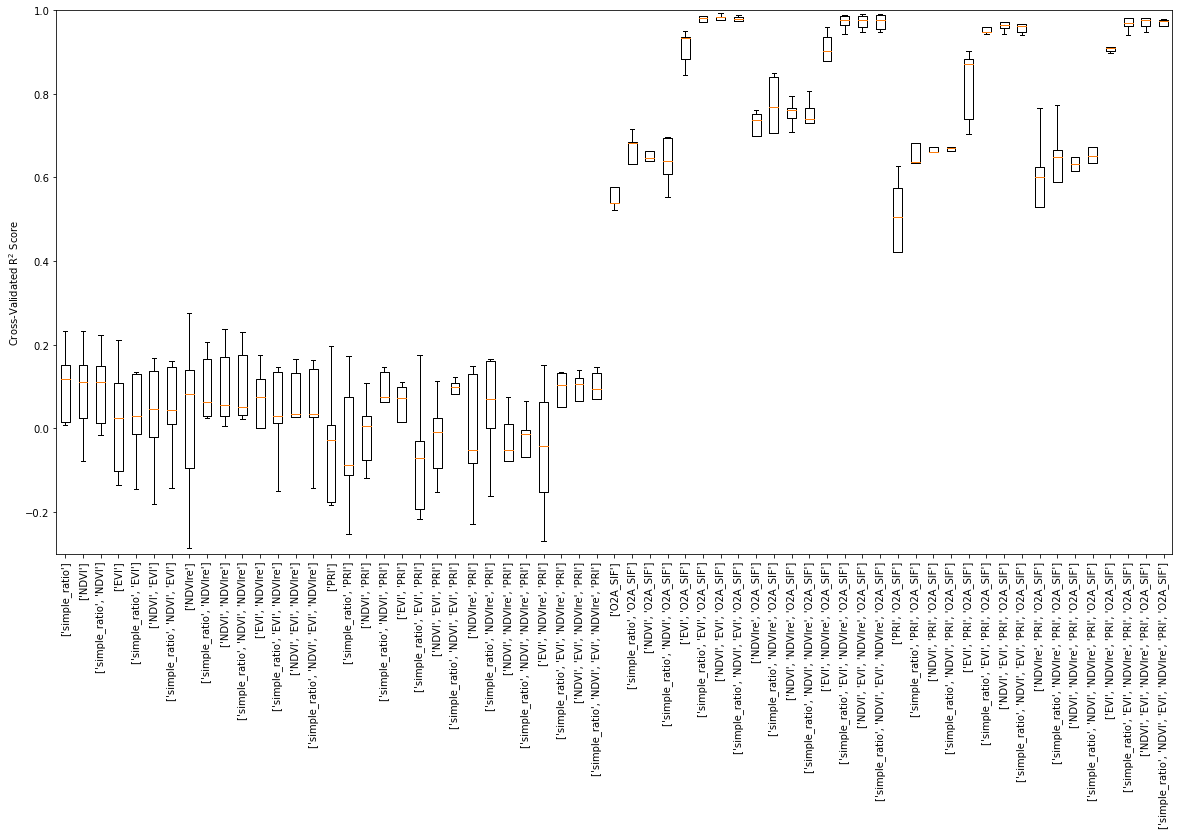

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20, 10))
ax.boxplot(scores_df['r2'], showfliers = False)
ax.set_xticks(range(1, len(scores_df) + 1))
ax.set_xticklabels(np.asarray(scores_df['features']), rotation = 90)
ax.set_ylim(-0.3, 1)
ax.set_ylabel(r'Cross-Validated R$^2$ Score')